In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

In [2]:
# defines function to create fancy plots

def sm_logit_plot(X_passed, y_passed, results_passed, parameter):
    """creates fancy plots for statsmodels.api.Logit.fit data. 
    X_passed ... single regression feature
    y_passed ... label
    results_passed ... statsmodels.api.Logit.fit
    parameter ... parameter name
    """
    global lgd, acr # pyplot.savefig() needs these to set right fig size. globals bad but me lazy...
                
                        ### some calculations to plot later on ###
    # calculates turning point of the sigmoid func by solvin .5 = 1/(1+exp(-(beta_0 + beta_1*x)))
    x_TP = -results_passed.params[0]/results_passed.params[1]

    ### seperates bad predictions
    yass = [] 
    nah =   []
    for x_, y_ in zip(X_passed, y_passed):
        if x_>x_TP and y_==0:  # false positive
            nah.append((x_, y_))
        elif x_<x_TP and y_==1:  # false negative
            nah.append((x_, y_))
        else: yass.append((x_, y_))

    # calculates p(x) to plot sigmoid
    # https://de.wikipedia.org/wiki/Logistische_Regression
    x_it = np.linspace(-(max(abs(X_passed))+0.5), (max(abs(X_passed))+0.5), 300)
    lin_predict = results_passed.params[0] + results_passed.params[1]*x_it
    inv_logit = 1/(1 + np.exp(-lin_predict))

    # calculates p(x) for inherited x
    # some jazz needed for the thin lines from the measured points to the fit 
    x_vodoo = []
    y_vodoo = []
    for x_, y_ in zip(X_passed, y_passed):
        lin_predict_re = results_passed.params[0] + results_passed.params[1]*x_
        inv_logit_re = 1/(1 + np.exp(-lin_predict_re))
        x_vodoo.append([x_]*2)
        y_vodoo.append([y_, inv_logit_re])

    # confusion matrix to plot patches with true positive, false, positive, true negative...
    predicted = (results_passed.predict(sm.add_constant(X_passed))>0.5).astype(int) #... binary class
    cf = confusion_matrix(y_passed, predicted)  # see: sklearn.metrics.confusion_matrix

    # calculates accuracy, sensitivity and specificity
    accuracy = np.mean(y_passed == predicted)
    sensivity = cf[0][0]/(cf[0][0]+cf[0][1])
    specificity = cf[1][1]/(cf[1][1]+cf[1][0])
    
    
                            ### plot ###
    # header
    plt.clf()
    fig, ax = plt.subplots(1, figsize=(12,6), dpi=100)
    fig.suptitle("log. Reg. für {}".format(parameter), x=0.2, y=0.92, ha="center")
    ax.set_title("statsmodels.api.Logit()", loc="right")
    ax.axis([-(max(abs(X_passed))+0.3), max(abs(X_passed))+0.3, -0.05, 1.05])
    
    #axes
    ax.axhline(0.5, color="black", alpha=0.9, linewidth=0.8)
    ax.axvline(x_TP, color="black", alpha=0.9, linewidth=0.8)
    # fited sigmoid curve
    ax.plot(x_it, inv_logit, linewidth=3, color="tomato", zorder=2, label=r"$P~( Y = 1~ |~ X) ~=~ \frac{1}{1+e^{-(\beta_{0}+\beta_{1}\cdot x)}}$ mit Modellkoeffizienten $\beta_{i}$.")            
    # markers on fit
    ax.scatter(X_passed, [j[1] for j in y_vodoo], zorder=3, marker="o", edgecolor="black", facecolor="skyblue", s= 50, label=r"$P~(Y=1~|~X)$ für den Datensatz.")
    # green and red flags aka measured data
    ax.scatter(*zip(*yass), color="limegreen", marker="|", zorder=10, s=250, label="Korrekt modelliert.")
    ax.scatter(*zip(*nah), color="firebrick", marker="|", zorder=10, s=250, label="Falsch modelliert.") 
    #thin lines
    for x_, y_ in zip(x_vodoo, y_vodoo):
        ax.plot(x_, y_, color="gray", linestyle="-", zorder=1, linewidth=0.7, alpha=0.3)

                                ### patches ###
    # false negative
    props = dict(boxstyle="round", facecolor="firebrick", edgecolor="black", alpha=0.5)
    ax.text(0.13, 0.63, "FN: \n{}".format(cf[1][0]), transform=ax.transAxes, bbox=props, fontsize=16, ha="center", fontweight="bold", zorder=6)
    # true positive
    props = dict(boxstyle="round", facecolor="limegreen", edgecolor="black", alpha=0.5)
    ax.text(0.87, 0.63, "TP: \n{}".format(cf[0][0]), transform=ax.transAxes, bbox=props, fontsize=16, ha="center", fontweight="bold", zorder=6)
    # false positive
    props = dict(boxstyle="round", facecolor="firebrick", edgecolor="black", alpha=0.5)
    ax.text(0.87, 0.28, "FP: \n{}".format(cf[0][1]), transform=ax.transAxes, bbox=props, fontsize=16, ha="center", fontweight="bold", zorder=6)
    # true negative
    props = dict(boxstyle="round", facecolor="limegreen", edgecolor="black", alpha=0.5)
    ax.text(0.13, 0.28, "TN: \n{}".format(cf[1][1]), transform=ax.transAxes, bbox=props, fontsize=16, ha="center", fontweight="bold", zorder=6)
    # accuracy patch
    props = dict( facecolor="white", edgecolor="black", alpha=1)
    acr = ax.text(0.2, -0.3, "accuracy: {:.2f} \n sensitivity: {:.2f} \n specificity: {:.2f} ".format(accuracy, sensivity, specificity), transform=ax.transAxes, bbox=props, fontsize=16, ha="center", fontweight="bold", zorder=6)
    # legend
    lgd = ax.legend(fontsize=14, loc="lower right", bbox_to_anchor=(1,-0.4))
    plt.show()
    return(fig)



# Bestehende Erfolgsquote

In [62]:
erfolgsquote = y["Lawine"].sum()/y["Lawine"].shape[0] 
print("Die bestehende Erfolgsquote liegt bei: ", erfolgsquote)

Die bestehende Erfolgsquote liegt bei:  0.52


# mittlere Änderung 24h vor Sprengung

In [63]:
# loads data
mitÄnderung = pd.read_pickle("./output/mitAEnderung_24_norm.pkl")
print("shape: ", mitÄnderung.shape)
print(mitÄnderung.head(4))
print("\nvalue counts for the labels column: \n",mitÄnderung["Lawine"].value_counts())

# splits dataframe
X = mitÄnderung.drop("Lawine", axis=1)
y = mitÄnderung.loc[:,"Lawine"]
smote = SMOTE(random_state=7)
X_res, y_res = smote.fit_resample(X,y)

print("\nvalue counts for the labels column after synthetic minority oversampling (SMOTE):\n", y_res.value_counts())

shape:  (50, 5)
   k: stability class   k: Sdef   k: Sn38   k: Sk38  Lawine
0            0.042679 -0.494814  1.078142 -0.038793       0
1            0.042679  0.029107  0.852966 -0.038793       0
2            0.042679 -0.320174 -3.290269  0.128419       1
3            0.042679  0.494814 -3.650550 -0.908298       0

value counts for the labels column: 
 1    26
0    24
Name: Lawine, dtype: int64

value counts for the labels column after synthetic minority oversampling (SMOTE):
 1    26
0    26
Name: Lawine, dtype: int64


Optimization terminated successfully.
         Current function value: 0.692269
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 Lawine   No. Observations:                   52
Model:                          Logit   Df Residuals:                       50
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                0.001267
Time:                        11:26:43   Log-Likelihood:                -35.998
converged:                       True   LL-Null:                       -36.044
Covariance Type:            nonrobust   LLR p-value:                    0.7625
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0002      0.278      0.001      0.999      -0.544       0.544
k: st

<Figure size 432x288 with 0 Axes>

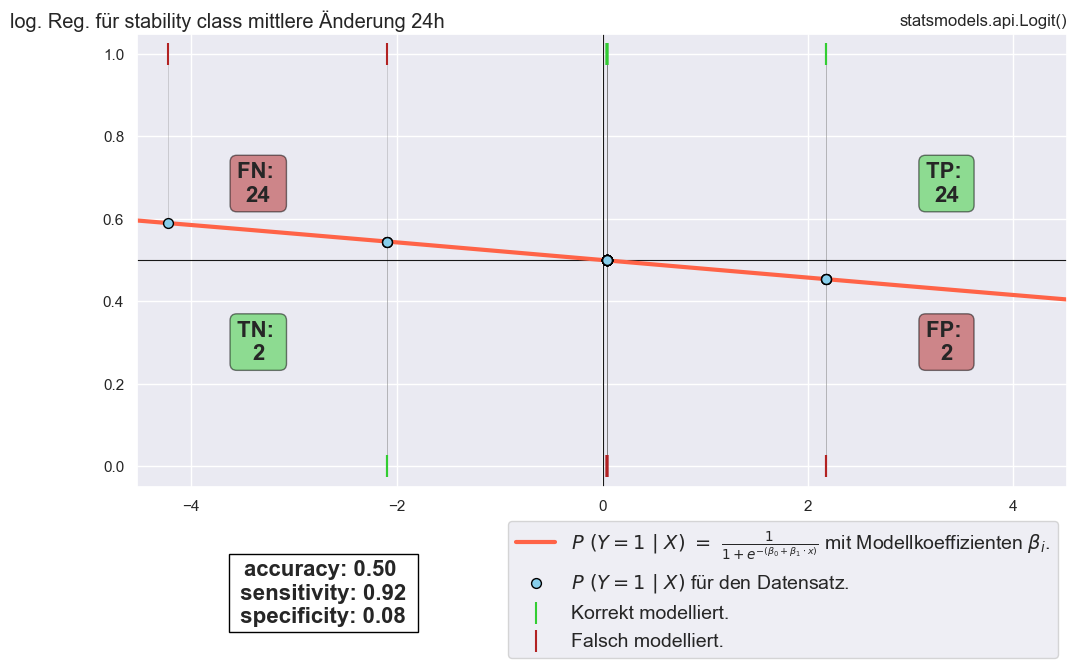

In [64]:
                        ### stability class ##
# log reg model
model = sm.Logit(y_res, sm.add_constant(X_res["k: stability class"]))
results = model.fit()
print(results.summary())
# calls plot func 
fig = sm_logit_plot(X_res["k: stability class"], y_res, results, "stability class mittlere Änderung 24h")
#fig.savefig("./output/test_plot.png", bbox_extra_artists=(lgd, acr), bbox_inches="tight") #bboxes outside axes need some love

Optimization terminated successfully.
         Current function value: 0.657949
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 Lawine   No. Observations:                   52
Model:                          Logit   Df Residuals:                       50
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                 0.05078
Time:                        11:26:54   Log-Likelihood:                -34.213
converged:                       True   LL-Null:                       -36.044
Covariance Type:            nonrobust   LLR p-value:                   0.05571
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1329      0.324     -0.410      0.681      -0.768       0.502
k: Sdef        1.1638      0.

<Figure size 432x288 with 0 Axes>

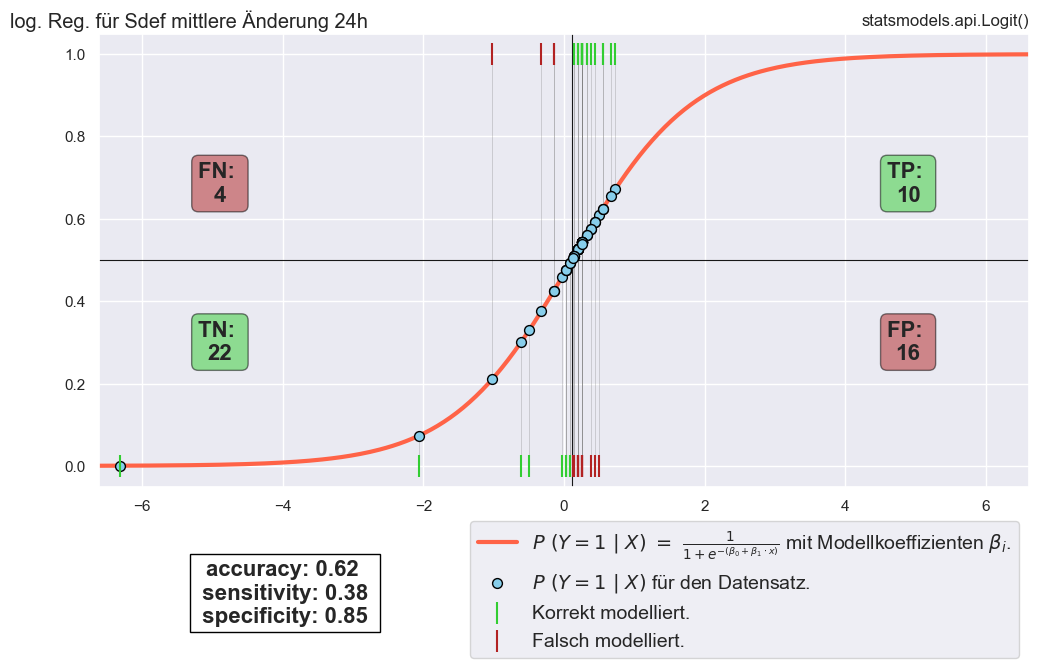

In [65]:
                        ### Sdef ##
# log reg model
model = sm.Logit(y_res, sm.add_constant(X_res["k: Sdef"]))
results = model.fit()
print(results.summary())
# calls plot func 
fig = sm_logit_plot(X_res["k: Sdef"], y_res, results, "Sdef mittlere Änderung 24h")
#fig.savefig("./output/test_plot.png", bbox_extra_artists=(lgd, acr), bbox_inches="tight") #bboxes outside axes need some love

Optimization terminated successfully.
         Current function value: 0.692221
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 Lawine   No. Observations:                   52
Model:                          Logit   Df Residuals:                       50
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                0.001337
Time:                        11:27:11   Log-Likelihood:                -35.995
converged:                       True   LL-Null:                       -36.044
Covariance Type:            nonrobust   LLR p-value:                    0.7563
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.278      0.004      0.997      -0.543       0.545
k: Sn38       -0.0880      0.

<Figure size 432x288 with 0 Axes>

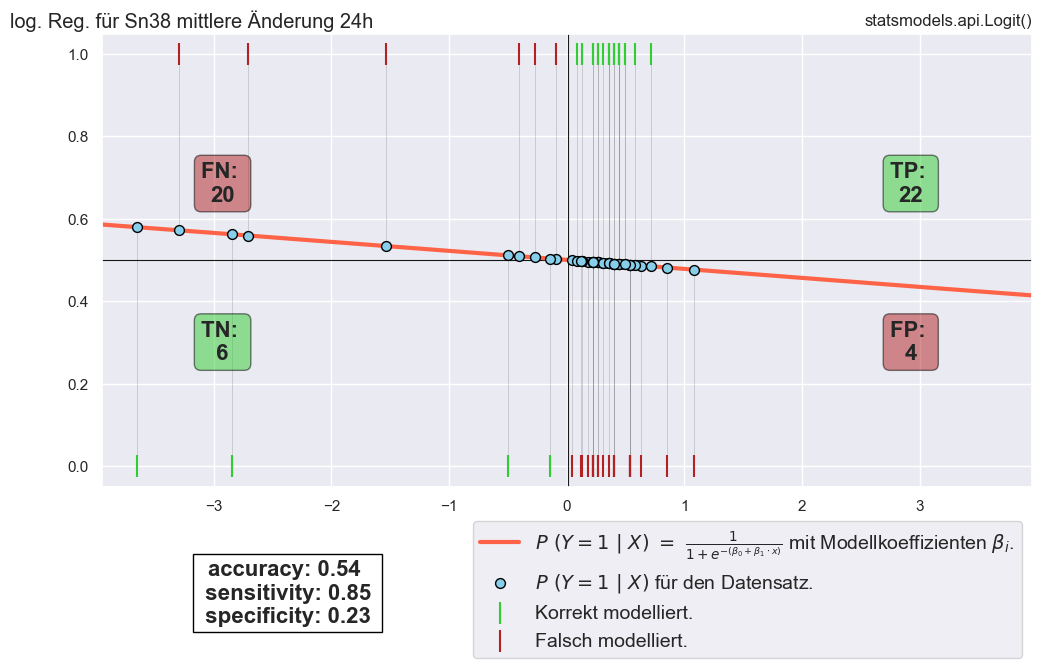

In [66]:
                        ### Sn38 ##
# log reg model
model = sm.Logit(y_res, sm.add_constant(X_res["k: Sn38"]))
results = model.fit()
print(results.summary())
# calls plot func 
fig = sm_logit_plot(X_res["k: Sn38"], y_res, results, "Sn38 mittlere Änderung 24h")
#fig.savefig("./output/test_plot.png", bbox_extra_artists=(lgd, acr), bbox_inches="tight") #bboxes outside axes need some love

Optimization terminated successfully.
         Current function value: 0.651093
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Lawine   No. Observations:                   52
Model:                          Logit   Df Residuals:                       50
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                 0.06067
Time:                        11:27:16   Log-Likelihood:                -33.857
converged:                       True   LL-Null:                       -36.044
Covariance Type:            nonrobust   LLR p-value:                   0.03650
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0103      0.289     -0.036      0.971      -0.577       0.556
k: Sk38        0.7411      0.

<Figure size 432x288 with 0 Axes>

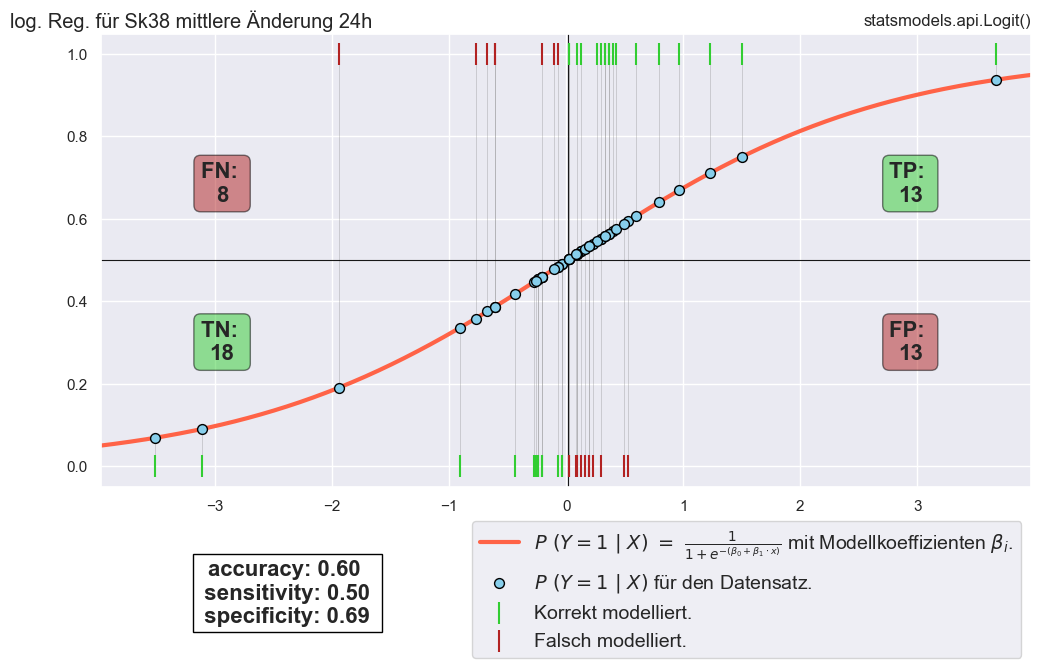

In [67]:
                        ### Sk38 ##
# log reg model
model = sm.Logit(y_res, sm.add_constant(X_res["k: Sk38"]))
results = model.fit()
print(results.summary())
# calls plot func 
fig = sm_logit_plot(X_res["k: Sk38"], y_res, results, "Sk38 mittlere Änderung 24h")
#fig.savefig("./output/test_plot.png", bbox_extra_artists=(lgd, acr), bbox_inches="tight") #bboxes outside axes need some love

# mittlere Änderung 12h vor Sprengung

In [68]:
# loads data
mitÄnderung = pd.read_pickle("./output/mitAEnderung_12_norm.pkl")
print("shape: ", mitÄnderung.shape)
print(mitÄnderung.head(4))
print("\nvalue counts for the labels column: \n",mitÄnderung["Lawine"].value_counts())

# splits dataframe
X = mitÄnderung.drop("Lawine", axis=1)
y = mitÄnderung.loc[:,"Lawine"]
smote = SMOTE(random_state=7)
X_res, y_res = smote.fit_resample(X,y)

print("\nvalue counts for the labels column after synthetic minority oversampling (SMOTE):\n", y_res.value_counts())

shape:  (50, 5)
   k: stability class   k: Sdef   k: Sn38   k: Sk38  Lawine
0            0.042679 -0.494814  1.078142 -0.038793       0
1            0.042679  0.029107  0.852966 -0.038793       0
2            0.042679 -0.320174 -3.290269  0.128419       1
3            0.042679  0.494814 -3.650550 -0.908298       0

value counts for the labels column: 
 1    26
0    24
Name: Lawine, dtype: int64

value counts for the labels column after synthetic minority oversampling (SMOTE):
 1    26
0    26
Name: Lawine, dtype: int64


Optimization terminated successfully.
         Current function value: 0.692269
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 Lawine   No. Observations:                   52
Model:                          Logit   Df Residuals:                       50
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                0.001267
Time:                        11:27:53   Log-Likelihood:                -35.998
converged:                       True   LL-Null:                       -36.044
Covariance Type:            nonrobust   LLR p-value:                    0.7625
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0002      0.278      0.001      0.999      -0.544       0.544
k: st

<Figure size 432x288 with 0 Axes>

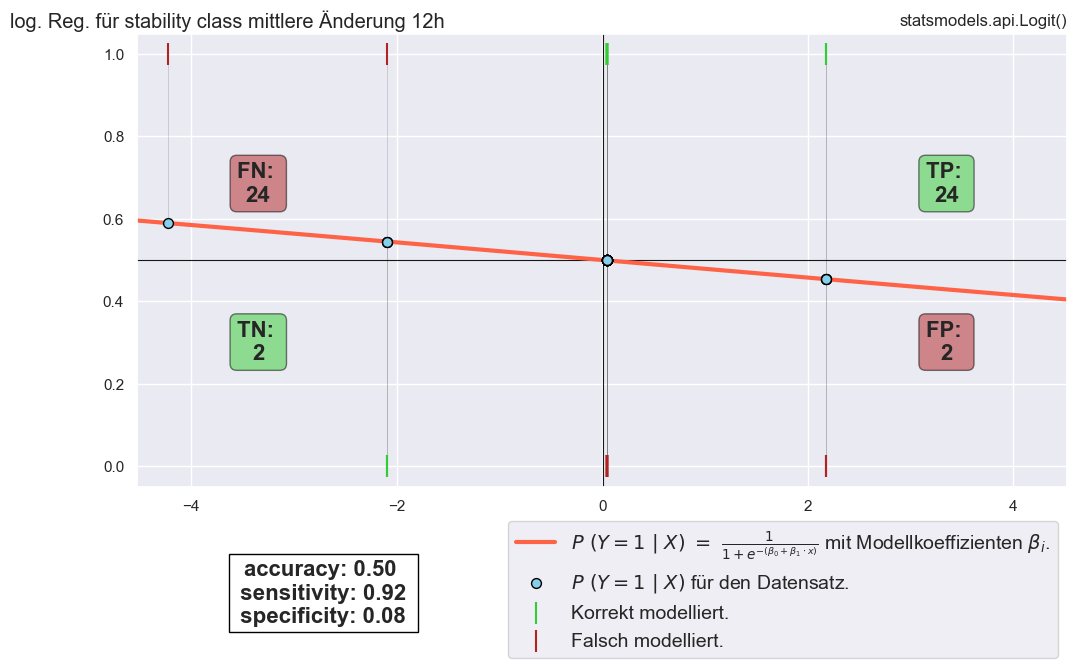

In [69]:
                        ### stability class ##
# log reg model
model = sm.Logit(y_res, sm.add_constant(X_res["k: stability class"]))
results = model.fit()
print(results.summary())
# calls plot func 
fig = sm_logit_plot(X_res["k: stability class"], y_res, results, "stability class mittlere Änderung 12h")
#fig.savefig("./output/test_plot.png", bbox_extra_artists=(lgd, acr), bbox_inches="tight") #bboxes outside axes need some love

Optimization terminated successfully.
         Current function value: 0.657949
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 Lawine   No. Observations:                   52
Model:                          Logit   Df Residuals:                       50
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                 0.05078
Time:                        11:28:02   Log-Likelihood:                -34.213
converged:                       True   LL-Null:                       -36.044
Covariance Type:            nonrobust   LLR p-value:                   0.05571
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1329      0.324     -0.410      0.681      -0.768       0.502
k: Sdef        1.1638      0.

<Figure size 432x288 with 0 Axes>

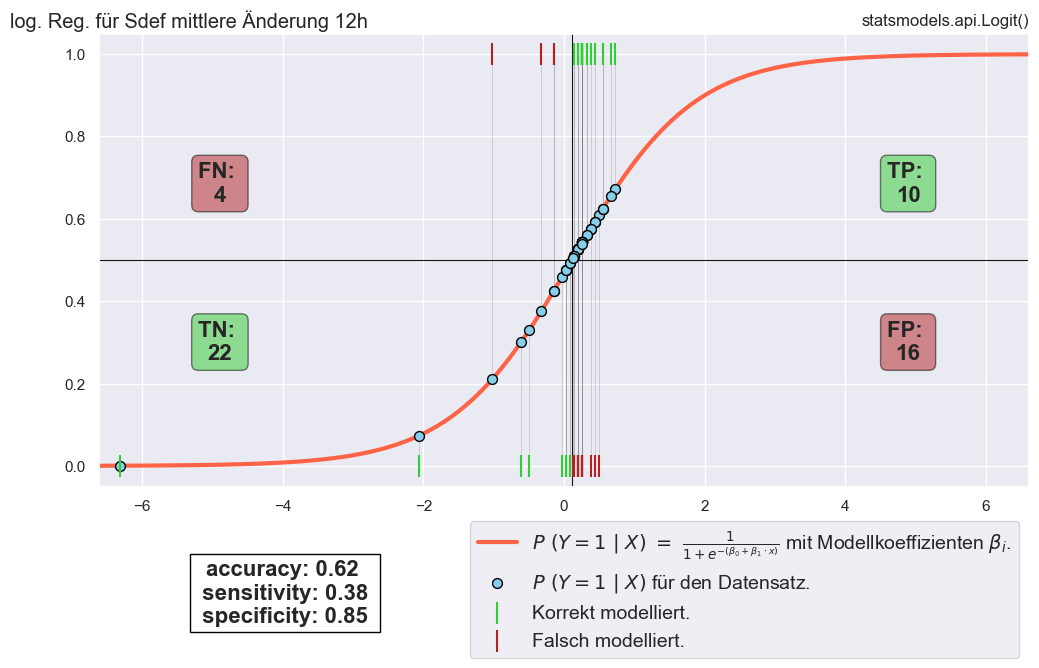

In [70]:
                        ### Sdef ##
# log reg model
model = sm.Logit(y_res, sm.add_constant(X_res["k: Sdef"]))
results = model.fit()
print(results.summary())
# calls plot func 
fig = sm_logit_plot(X_res["k: Sdef"], y_res, results, "Sdef mittlere Änderung 12h")
#fig.savefig("./output/test_plot.png", bbox_extra_artists=(lgd, acr), bbox_inches="tight") #bboxes outside axes need some love

Optimization terminated successfully.
         Current function value: 0.692221
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 Lawine   No. Observations:                   52
Model:                          Logit   Df Residuals:                       50
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                0.001337
Time:                        11:28:15   Log-Likelihood:                -35.995
converged:                       True   LL-Null:                       -36.044
Covariance Type:            nonrobust   LLR p-value:                    0.7563
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.278      0.004      0.997      -0.543       0.545
k: Sn38       -0.0880      0.

<Figure size 432x288 with 0 Axes>

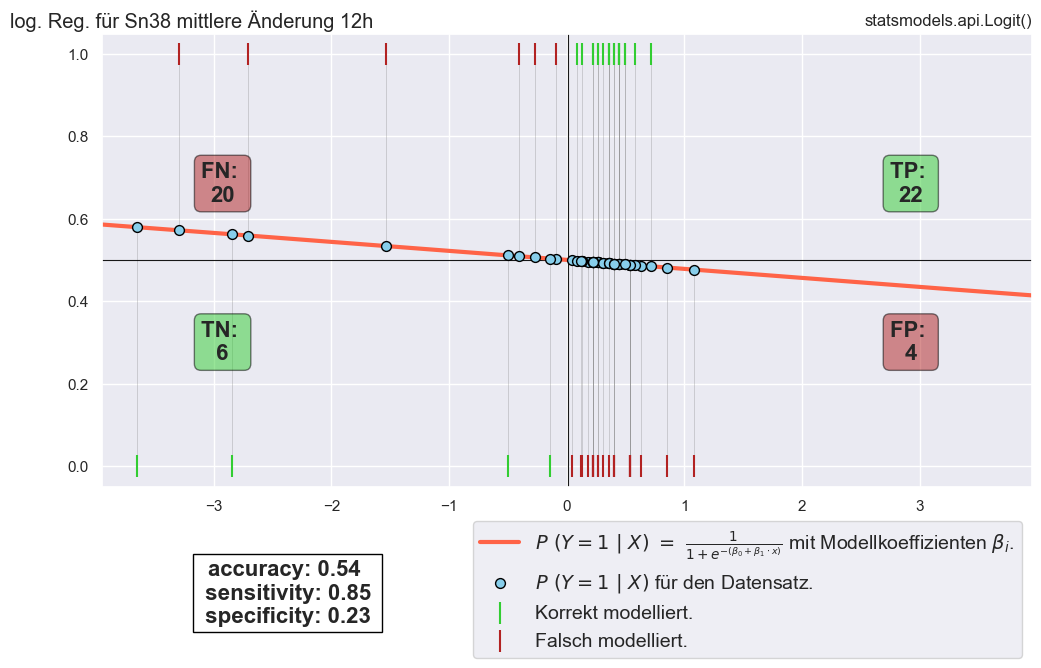

In [71]:
                        ### Sn38 ##
# log reg model
model = sm.Logit(y_res, sm.add_constant(X_res["k: Sn38"]))
results = model.fit()
print(results.summary())
# calls plot func 
fig = sm_logit_plot(X_res["k: Sn38"], y_res, results, "Sn38 mittlere Änderung 12h")
#fig.savefig("./output/test_plot.png", bbox_extra_artists=(lgd, acr), bbox_inches="tight") #bboxes outside axes need some love

Optimization terminated successfully.
         Current function value: 0.651093
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Lawine   No. Observations:                   52
Model:                          Logit   Df Residuals:                       50
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                 0.06067
Time:                        11:28:22   Log-Likelihood:                -33.857
converged:                       True   LL-Null:                       -36.044
Covariance Type:            nonrobust   LLR p-value:                   0.03650
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0103      0.289     -0.036      0.971      -0.577       0.556
k: Sk38        0.7411      0.

<Figure size 432x288 with 0 Axes>

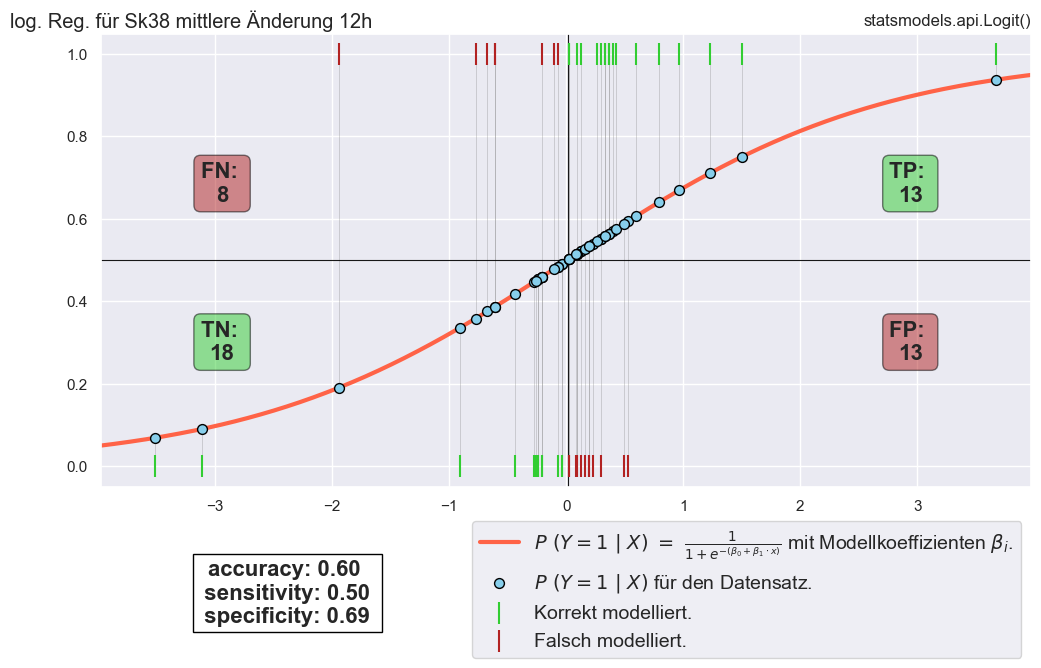

In [72]:
                        ### Sk38 ##
# log reg model
model = sm.Logit(y_res, sm.add_constant(X_res["k: Sk38"]))
results = model.fit()
print(results.summary())
# calls plot func 
fig = sm_logit_plot(X_res["k: Sk38"], y_res, results, "Sk38 mittlere Änderung 12h")
#fig.savefig("./output/test_plot.png", bbox_extra_artists=(lgd, acr), bbox_inches="tight") #bboxes outside axes need some love

# mittlere Änderung 6h vor Sprengung

In [73]:
# loads data
mitÄnderung = pd.read_pickle("./output/mitAEnderung_6_norm.pkl")
print("shape: ", mitÄnderung.shape)
print(mitÄnderung.head(4))
print("\nvalue counts for the labels column: \n",mitÄnderung["Lawine"].value_counts())

# splits dataframe
X = mitÄnderung.drop("Lawine", axis=1)
y = mitÄnderung.loc[:,"Lawine"]
smote = SMOTE(random_state=7)
X_res, y_res = smote.fit_resample(X,y)

print("\nvalue counts for the labels column after synthetic minority oversampling (SMOTE):\n", y_res.value_counts())

shape:  (50, 5)
   k: stability class   k: Sdef   k: Sn38   k: Sk38  Lawine
0           -0.204124 -1.266179 -0.187135 -0.692648       0
1           -0.204124 -0.071670  0.644576 -0.477540       0
2           -0.204124 -0.469840 -2.266411  0.167784       1
3           -0.204124  0.724668 -4.553615 -0.477540       0

value counts for the labels column: 
 1    26
0    24
Name: Lawine, dtype: int64

value counts for the labels column after synthetic minority oversampling (SMOTE):
 1    26
0    26
Name: Lawine, dtype: int64


Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
                           Logit Regression Results                           
Dep. Variable:                 Lawine   No. Observations:                   52
Model:                          Logit   Df Residuals:                       50
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                   0.000
Time:                        11:28:37   Log-Likelihood:                -36.044
converged:                       True   LL-Null:                       -36.044
Covariance Type:            nonrobust   LLR p-value:                     1.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                       0      0.277          0      1.000      -0.544       0.544
k: st

C:\Users\mitte\Anaconda3\envs\imbalearn\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

<Figure size 432x288 with 0 Axes>

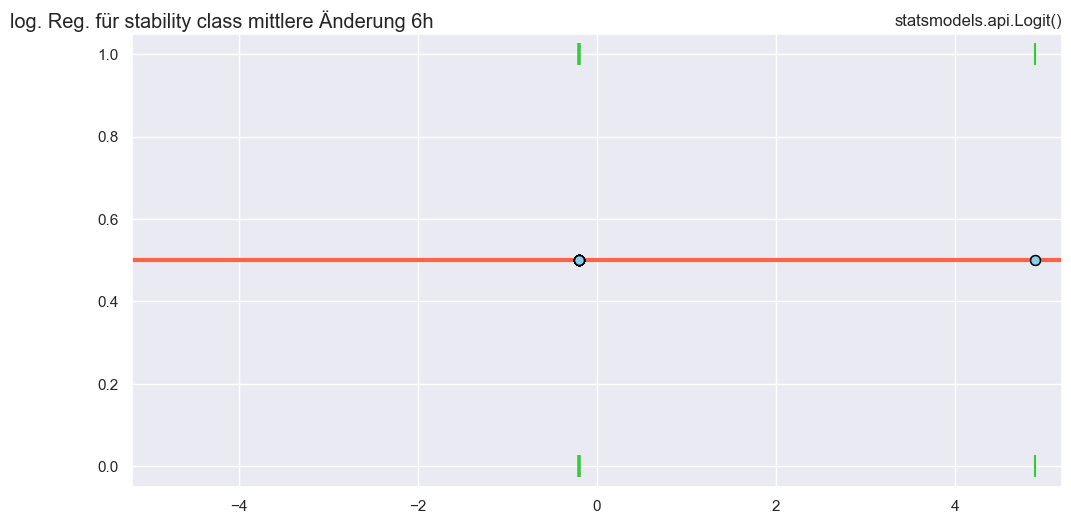

In [74]:
                        ### stability class ##
# log reg model
model = sm.Logit(y_res, sm.add_constant(X_res["k: stability class"]))
results = model.fit()
print(results.summary())
# calls plot func 
fig = sm_logit_plot(X_res["k: stability class"], y_res, results, "stability class mittlere Änderung 6h")
#fig.savefig("./output/test_plot.png", bbox_extra_artists=(lgd, acr), bbox_inches="tight") #bboxes outside axes need some love

Optimization terminated successfully.
         Current function value: 0.666286
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Lawine   No. Observations:                   52
Model:                          Logit   Df Residuals:                       50
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                 0.03875
Time:                        11:28:45   Log-Likelihood:                -34.647
converged:                       True   LL-Null:                       -36.044
Covariance Type:            nonrobust   LLR p-value:                   0.09464
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0363      0.290     -0.125      0.900      -0.605       0.532
k: Sdef        0.5848      0.

<Figure size 432x288 with 0 Axes>

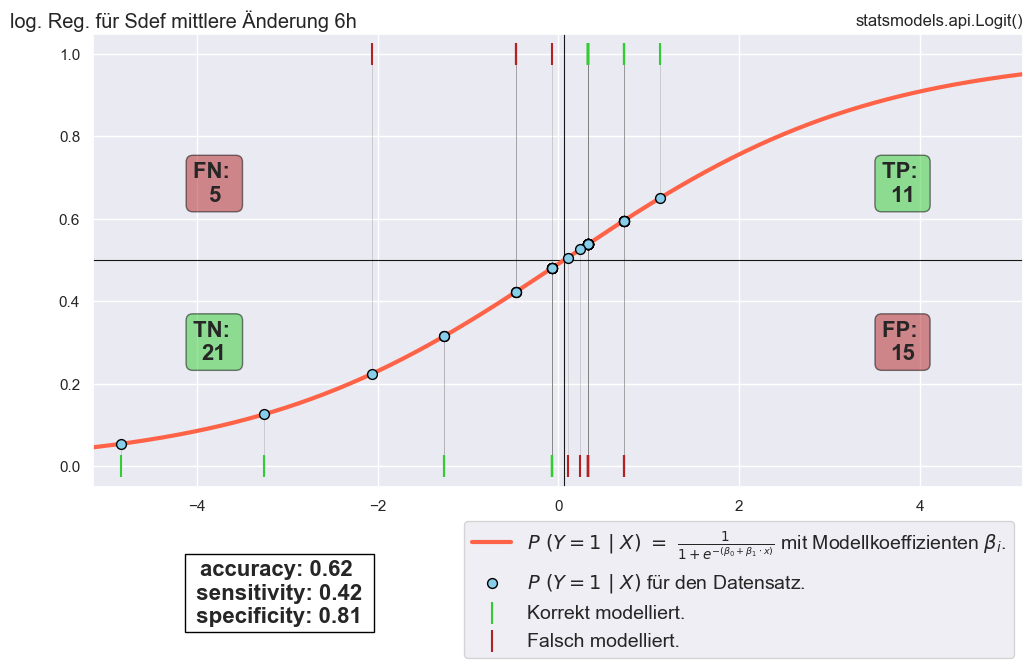

In [75]:
                        ### Sdef ##
# log reg model
model = sm.Logit(y_res, sm.add_constant(X_res["k: Sdef"]))
results = model.fit()
print(results.summary())
# calls plot func 
fig = sm_logit_plot(X_res["k: Sdef"], y_res, results, "Sdef mittlere Änderung 6h")
#fig.savefig("./output/test_plot.png", bbox_extra_artists=(lgd, acr), bbox_inches="tight") #bboxes outside axes need some love

Optimization terminated successfully.
         Current function value: 0.688236
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 Lawine   No. Observations:                   52
Model:                          Logit   Df Residuals:                       50
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                0.007086
Time:                        11:29:01   Log-Likelihood:                -35.788
converged:                       True   LL-Null:                       -36.044
Covariance Type:            nonrobust   LLR p-value:                    0.4748
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.279      0.002      0.998      -0.546       0.547
k: Sn38       -0.2078      0.

<Figure size 432x288 with 0 Axes>

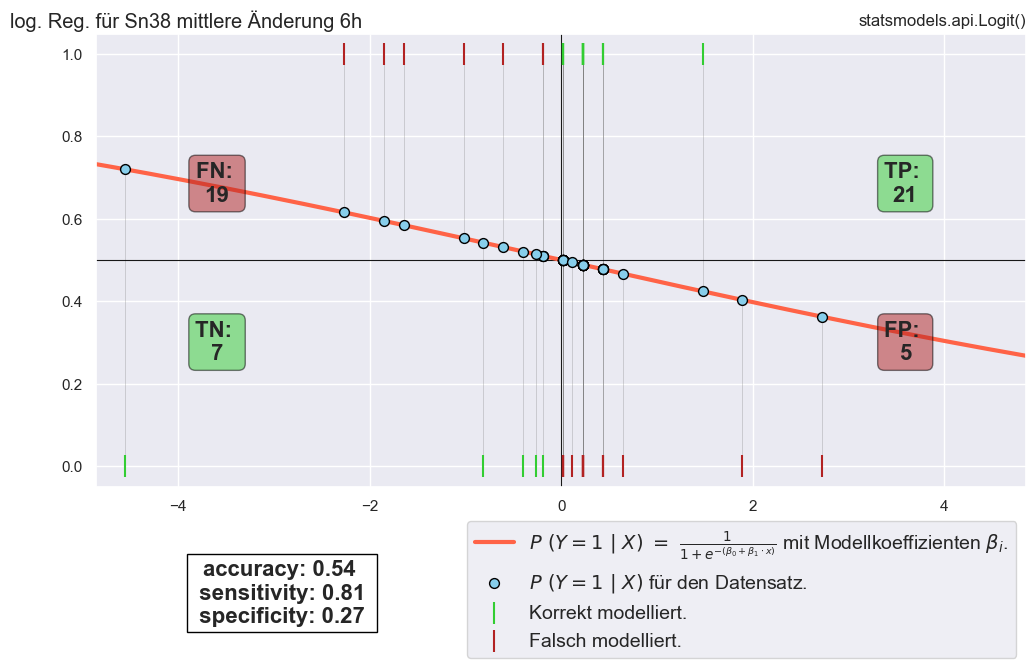

In [76]:
                        ### Sn38 ##
# log reg model
model = sm.Logit(y_res, sm.add_constant(X_res["k: Sn38"]))
results = model.fit()
print(results.summary())
# calls plot func 
fig = sm_logit_plot(X_res["k: Sn38"], y_res, results, "Sn38 mittlere Änderung 6h")
#fig.savefig("./output/test_plot.png", bbox_extra_artists=(lgd, acr), bbox_inches="tight") #bboxes outside axes need some love

Optimization terminated successfully.
         Current function value: 0.654644
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 Lawine   No. Observations:                   52
Model:                          Logit   Df Residuals:                       50
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                 0.05555
Time:                        11:29:08   Log-Likelihood:                -34.041
converged:                       True   LL-Null:                       -36.044
Covariance Type:            nonrobust   LLR p-value:                   0.04538
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0262      0.289      0.091      0.928      -0.541       0.593
k: Sk38        0.6047      0.

<Figure size 432x288 with 0 Axes>

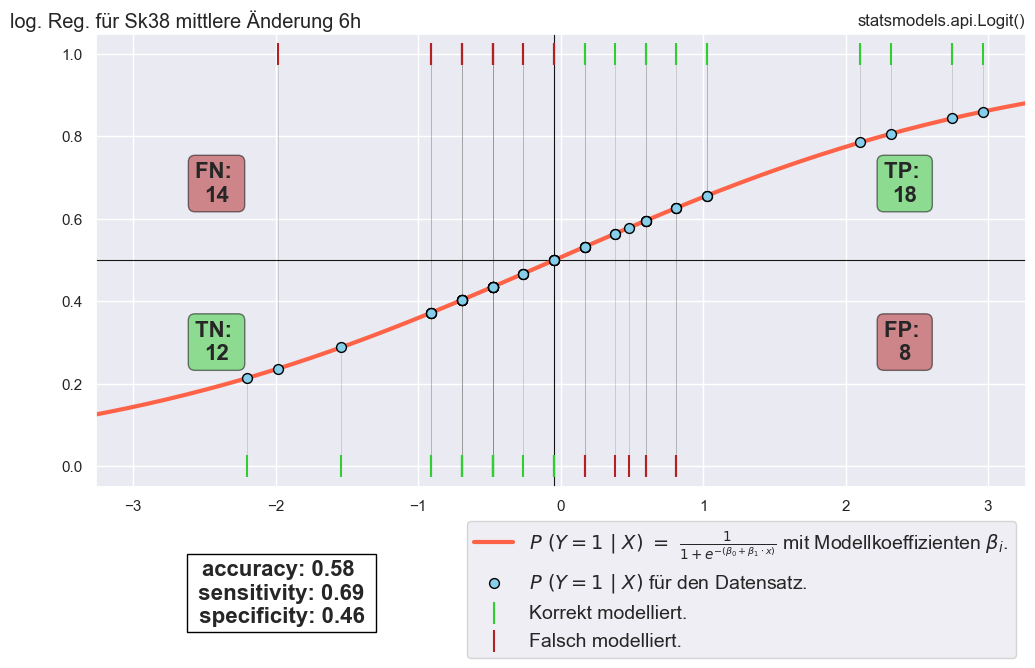

In [77]:
                        ### Sk38 ##
# log reg model
model = sm.Logit(y_res, sm.add_constant(X_res["k: Sk38"]))
results = model.fit()
print(results.summary())
# calls plot func 
fig = sm_logit_plot(X_res["k: Sk38"], y_res, results, "Sk38 mittlere Änderung 6h")
#fig.savefig("./output/test_plot.png", bbox_extra_artists=(lgd, acr), bbox_inches="tight") #bboxes outside axes need some love

# mittlere Änderung 3h vor Sprengung

In [78]:
# loads data
mitÄnderung = pd.read_pickle("./output/mitAEnderung_3_norm.pkl")
print("shape: ", mitÄnderung.shape)
print(mitÄnderung.head(4))
print("\nvalue counts for the labels column: \n",mitÄnderung["Lawine"].value_counts())

# splits dataframe
X = mitÄnderung.drop("Lawine", axis=1)
y = mitÄnderung.loc[:,"Lawine"]
smote = SMOTE(random_state=7)
X_res, y_res = smote.fit_resample(X,y)

print("\nvalue counts for the labels column after synthetic minority oversampling (SMOTE):\n", y_res.value_counts())

shape:  (50, 5)
   k: stability class   k: Sdef   k: Sn38   k: Sk38  Lawine
0           -0.204124 -1.266179 -0.187135 -0.692648       0
1           -0.204124 -0.071670  0.644576 -0.477540       0
2           -0.204124 -0.469840 -2.266411  0.167784       1
3           -0.204124  0.724668 -4.553615 -0.477540       0

value counts for the labels column: 
 1    26
0    24
Name: Lawine, dtype: int64

value counts for the labels column after synthetic minority oversampling (SMOTE):
 1    26
0    26
Name: Lawine, dtype: int64


Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
                           Logit Regression Results                           
Dep. Variable:                 Lawine   No. Observations:                   52
Model:                          Logit   Df Residuals:                       50
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                   0.000
Time:                        11:31:38   Log-Likelihood:                -36.044
converged:                       True   LL-Null:                       -36.044
Covariance Type:            nonrobust   LLR p-value:                     1.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                       0      0.277          0      1.000      -0.544       0.544
k: st

C:\Users\mitte\Anaconda3\envs\imbalearn\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

<Figure size 432x288 with 0 Axes>

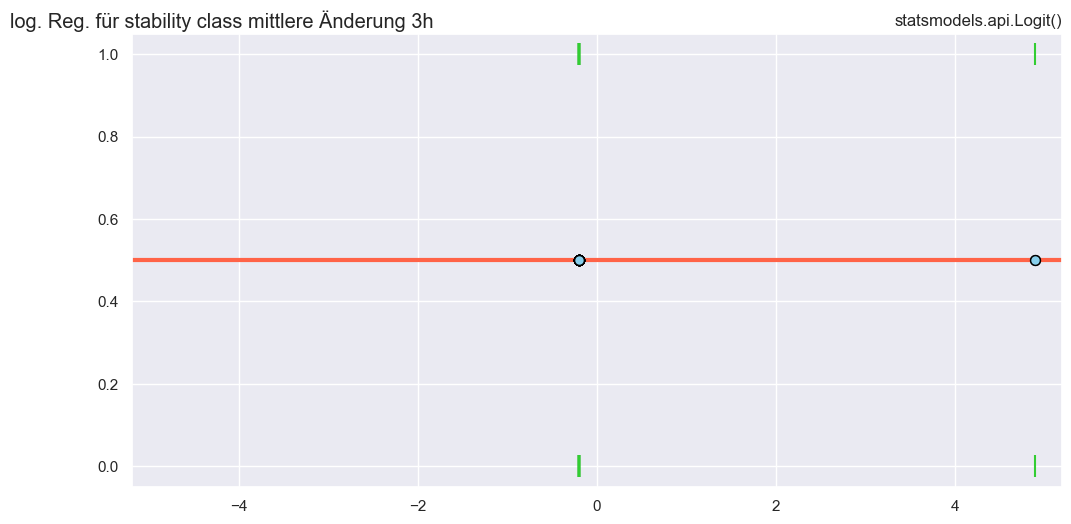

In [83]:
                        ### stability class ##
# log reg model
model = sm.Logit(y_res, sm.add_constant(X_res["k: stability class"]))
results = model.fit()
print(results.summary())
# calls plot func 
fig = sm_logit_plot(X_res["k: stability class"], y_res, results, "stability class mittlere Änderung 3h")
#fig.savefig("./output/test_plot.png", bbox_extra_artists=(lgd, acr), bbox_inches="tight") #bboxes outside axes need some love

Optimization terminated successfully.
         Current function value: 0.666286
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Lawine   No. Observations:                   52
Model:                          Logit   Df Residuals:                       50
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                 0.03875
Time:                        11:29:48   Log-Likelihood:                -34.647
converged:                       True   LL-Null:                       -36.044
Covariance Type:            nonrobust   LLR p-value:                   0.09464
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0363      0.290     -0.125      0.900      -0.605       0.532
k: Sdef        0.5848      0.

<Figure size 432x288 with 0 Axes>

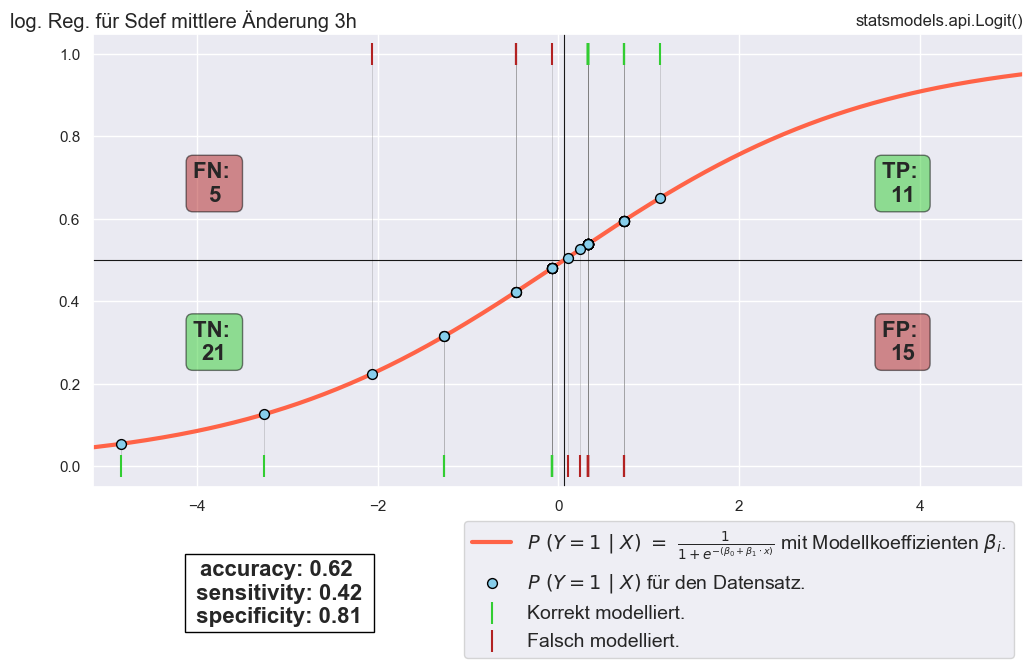

In [80]:
                        ### Sdef ##
# log reg model
model = sm.Logit(y_res, sm.add_constant(X_res["k: Sdef"]))
results = model.fit()
print(results.summary())
# calls plot func 
fig = sm_logit_plot(X_res["k: Sdef"], y_res, results, "Sdef mittlere Änderung 3h")
#fig.savefig("./output/test_plot.png", bbox_extra_artists=(lgd, acr), bbox_inches="tight") #bboxes outside axes need some love

Optimization terminated successfully.
         Current function value: 0.688236
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 Lawine   No. Observations:                   52
Model:                          Logit   Df Residuals:                       50
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                0.007086
Time:                        11:30:16   Log-Likelihood:                -35.788
converged:                       True   LL-Null:                       -36.044
Covariance Type:            nonrobust   LLR p-value:                    0.4748
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.279      0.002      0.998      -0.546       0.547
k: Sn38       -0.2078      0.

<Figure size 432x288 with 0 Axes>

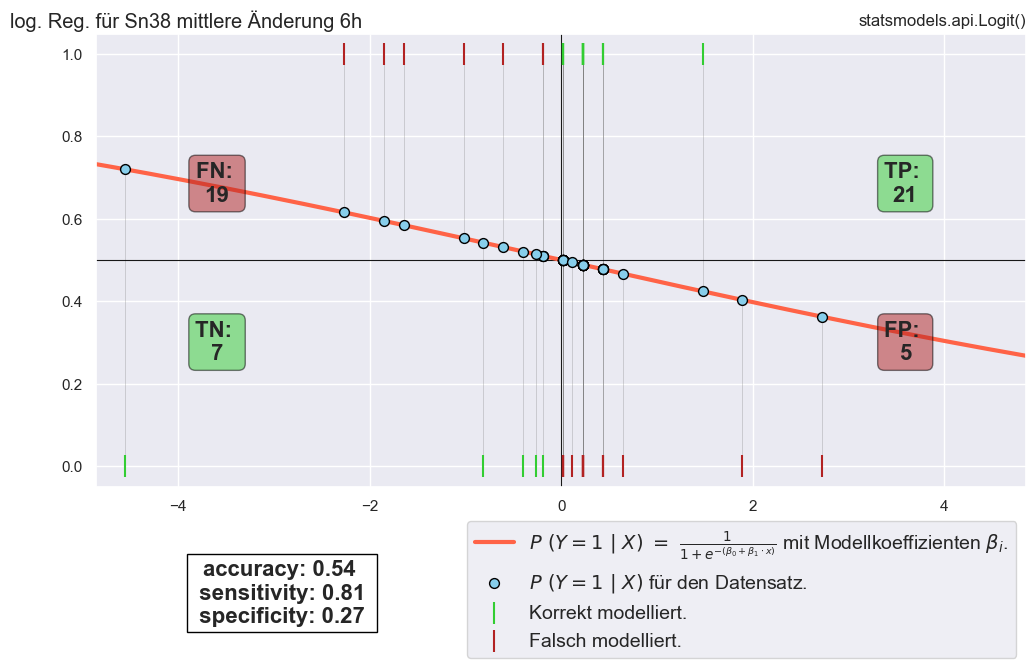

In [81]:
                        ### Sn38 ##
# log reg model
model = sm.Logit(y_res, sm.add_constant(X_res["k: Sn38"]))
results = model.fit()
print(results.summary())
# calls plot func 
fig = sm_logit_plot(X_res["k: Sn38"], y_res, results, "Sn38 mittlere Änderung 6h")
#fig.savefig("./output/test_plot.png", bbox_extra_artists=(lgd, acr), bbox_inches="tight") #bboxes outside axes need some love

Optimization terminated successfully.
         Current function value: 0.654644
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 Lawine   No. Observations:                   52
Model:                          Logit   Df Residuals:                       50
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                 0.05555
Time:                        11:30:27   Log-Likelihood:                -34.041
converged:                       True   LL-Null:                       -36.044
Covariance Type:            nonrobust   LLR p-value:                   0.04538
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0262      0.289      0.091      0.928      -0.541       0.593
k: Sk38        0.6047      0.

<Figure size 432x288 with 0 Axes>

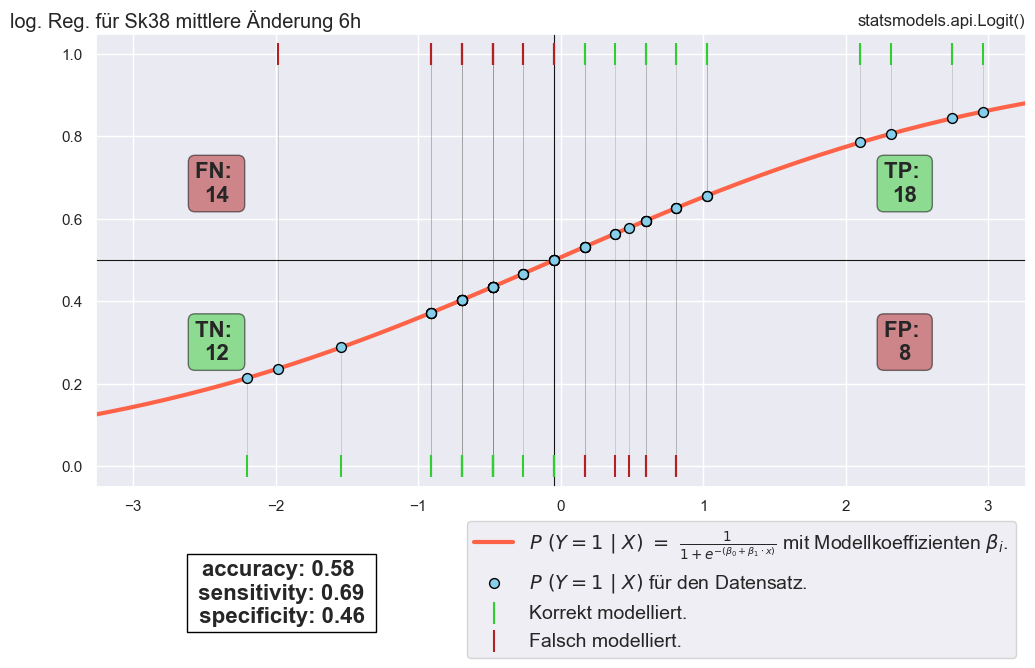

In [82]:
                        ### Sk38 ##
# log reg model
model = sm.Logit(y_res, sm.add_constant(X_res["k: Sk38"]))
results = model.fit()
print(results.summary())
# calls plot func 
fig = sm_logit_plot(X_res["k: Sk38"], y_res, results, "Sk38 mittlere Änderung 6h")
#fig.savefig("./output/test_plot.png", bbox_extra_artists=(lgd, acr), bbox_inches="tight") #bboxes outside axes need some love

# --------------------------------------------------------------
# Neuschnee 24 Stunden
Im Vergleich dazu Neuschneemenge in den letzten 24 Stunden.

In [44]:
schnee24_norm = pd.read_pickle("./output/schnee24_norm.pkl")
print("shape: ", schnee24_norm.shape)
print(schnee24_norm.head(5))

X = schnee24_norm.drop("Lawine", axis=1)
y = schnee24_norm.drop("HN24", axis=1)
print("\ny value counts for labels cloumn:\n", y["Lawine"].value_counts())

smote = SMOTE(random_state=7)
X_res, y_res = smote.fit_resample(X,y)
print("\nvalues count for labels coulumn after synthetic minority over sampling (SMOTE):\n", y_res["Lawine"].value_counts())

shape:  (50, 2)
       HN24  Lawine
0  1.836572       0
1 -1.899397       0
2  0.531657       1
3  1.239635       0
4 -1.899397       0

y value counts for labels cloumn:
 1    26
0    24
Name: Lawine, dtype: int64

values count for labels coulumn after synthetic minority over sampling (SMOTE):
 1    26
0    26
Name: Lawine, dtype: int64


Optimization terminated successfully.
         Current function value: 0.692634
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                 Lawine   No. Observations:                   52
Model:                          Logit   Df Residuals:                       50
Method:                           MLE   Df Model:                            1
Date:                Thu, 25 Jun 2020   Pseudo R-squ.:               0.0007402
Time:                        19:29:27   Log-Likelihood:                -36.017
converged:                       True   LL-Null:                       -36.044
Covariance Type:            nonrobust   LLR p-value:                    0.8173
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.277      0.001      0.999      -0.544       0.544
HN24          -0.0651      0.

<Figure size 432x288 with 0 Axes>

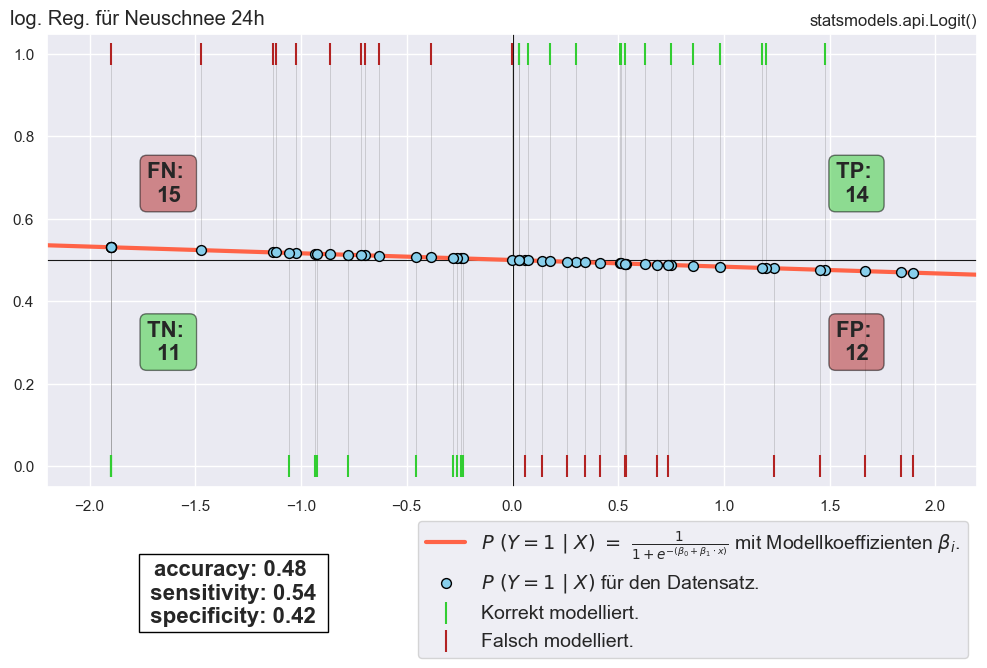

In [45]:
                        ### Neuschneemenge 24 Stunden vor Sprengzeitpunkt ##
# log reg model
model = sm.Logit(y_res, sm.add_constant(X_res["HN24"]))
results = model.fit()
print(results.summary())
# calls plot func 
fig = sm_logit_plot(X_res["HN24"], y_res["Lawine"], results, "Neuschnee 24h")
#fig.savefig("./output/test_plot.png", bbox_extra_artists=(lgd, acr), bbox_inches="tight") #bboxes outside axes need some love